# Exploratory analysis on conversational tweets

In this dataset, we extract all the conversations for three popular users

- MashiRafael (politics)
- aguschmer (sports)

- KarlaMoralesR (activism on humanitarian aid)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import os
import csv
import numpy as np

In [2]:
data_dir='~/data/twconv/twconv_2016_usersec'
data_dir=os.path.expanduser(data_dir)
fpath = os.path.join(data_dir, 'conversations_large.csv')
ds = pd.read_csv(fpath, parse_dates=['timestamp'])
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520263 entries, 0 to 520262
Data columns (total 14 columns):
id                       520263 non-null int64
screen_name              520263 non-null object
latitude                 4063 non-null float64
longitude                4063 non-null float64
lang                     520263 non-null object
in_reply_to_status_id    507354 non-null float64
created_at               520263 non-null object
text                     520263 non-null object
timestamp                520247 non-null datetime64[ns]
conversation_id          520263 non-null int64
conversation_deep        520263 non-null int64
num_replies              520263 non-null int64
num_users                520263 non-null int64
url                      520263 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(5)
memory usage: 55.6+ MB


520K tweets in the dataset, including: those popular users' tweets and all the replies.

## temporal distribution

Let's analyze the temporal distribution of the tweets

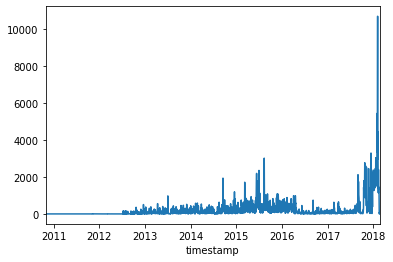

In [3]:
ds.groupby(ds['timestamp'].dt.date).size().plot()

the tweets begin in 2010, then steadily increase through the years with a huge spike in 2018 probably the referendum in february

## most active users

In [4]:
ds.groupby('screen_name').size().sort_values(ascending=False).head()

screen_name
MashiRafael      6212
aguschmer        6140
KarlaMoralesR    2575
marceloht40      1617
sejusto2015       834
dtype: int64

## number of tweets that start conversations

In [5]:
conv_users = ds[ds.in_reply_to_status_id.isnull()].groupby('screen_name')
conv_users.size().sort_values(ascending=False).head()

screen_name
aguschmer        5257
MashiRafael      5060
KarlaMoralesR    1768
adeljar            11
la_abogada_        11
dtype: int64

In [6]:
print(conv_users.size().shape[0])

652


## number of participants by conversation starter

In [7]:
participants_by_conv_starter = []
pcs = {}

for name, group in conv_users:
    conv_ids = group.id.values
    #conv_ids = ds[ds.screen_name==name].head().groupby('conversation_id').size().index.values
    conv_tweets = ds[ds.conversation_id.isin(conv_ids)]
    #print(name, conv_tweets.shape[0], conv_tweets.screen_name.nunique())
    participants_by_conv_starter.append((name, conv_tweets.shape[0], conv_tweets.screen_name.nunique()))
    pcs[name] = set(conv_tweets.screen_name.unique())
    #break

ds_participants = pd.DataFrame(participants_by_conv_starter, columns=['screen_name','num_replies','num_participants'])
ds_participants.sort_values(by='num_replies', ascending=False).head()

,screen_name,num_replies,num_participants
208,MashiRafael,413805,97682
326,aguschmer,79425,24219
173,KarlaMoralesR,12355,5290
36,BatichicaRC,489,207
579,pametroya,393,157


## users participating on conversations in different domains?

In [8]:
intersect = pcs['MashiRafael'].intersection(pcs['aguschmer'])
intersect2 = pcs['MashiRafael'].intersection(pcs['KarlaMoralesR'])
intersect3 = pcs['aguschmer'].intersection(pcs['KarlaMoralesR'])
print(len(intersect))
print(len(intersect2))
print(len(intersect3))

7699
2138
1945


In [9]:
(7699+2138+1945) / ds.screen_name.nunique()

0.09953451436584974

less than 10% of the total of the users

In [12]:
import networkx as nx
import numpy as np

In [13]:
#G.add_nodes_from(ds_participants.screen_name.values)

name_list=['MashiRafael','KarlaMoralesR','aguschmer']
color_list=['green', 'red', 'blue']
nodes_color = []
i = 0
G = nx.DiGraph()

for name, color in zip(name_list, color_list):
    nodes = list(pcs[name])
    sample_nodes=np.random.choice(nodes, int(len(nodes)*0.01),replace=False)
    for e in sample_nodes:
        G.add_edge(e, name)
        
name_list= []
name_list.append(('MashiRafael','aguschmer'))
name_list.append(('MashiRafael','KarlaMoralesR'))
name_list.append(('aguschmer','KarlaMoralesR'))

node_list = []
node_list.append(intersect)
node_list.append(intersect2)
node_list.append(intersect3)
intergroup = []

for names, nodes_ in zip(name_list, node_list):
    nodes = list(nodes_)
    sample_nodes = np.random.choice(nodes, int(len(nodes)*0.05), replace=False)

    for e in sample_nodes:
        G.add_edge(e, names[0])
        G.add_edge(e, names[1])
        intergroup.append(e)

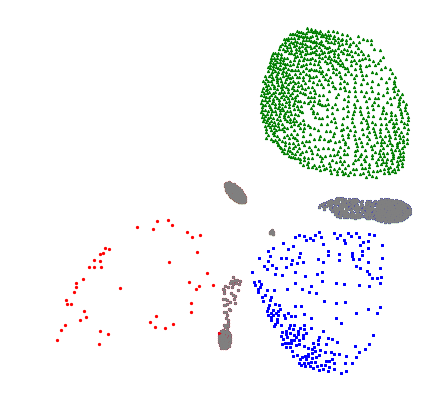

In [25]:
plt.figure
fig, ax = plt.subplots(figsize=(7,7))
ax.axis('off')
pos = nx.spring_layout(G,k=0.10 , iterations=40)  #so^>v<dph8 ,k=0.10,iterations=50
group = list(G.predecessors('MashiRafael'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=group, node_color='green', node_shape='^')
group = list(G.predecessors('aguschmer'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=group, node_color='blue', node_shape='s')
group = list(G.predecessors('KarlaMoralesR'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=group, node_color='red', node_shape='o')

nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=5, ax=ax, nodelist=intergroup, node_color='grey', node_shape='8')

# group=['MashiRafael','KarlaMoralesR','aguschmer']
# labels = {name:name for name in group}
# nx.draw_networkx_labels(G,pos,labels,font_size=14,font_color='black')

{'MashiRafael': Text(-0.0698278,0.452496,'MashiRafael'),
 'KarlaMoralesR': Text(-0.577164,-0.59597,'KarlaMoralesR'),
 'aguschmer': Text(0.208664,-0.876724,'aguschmer')}

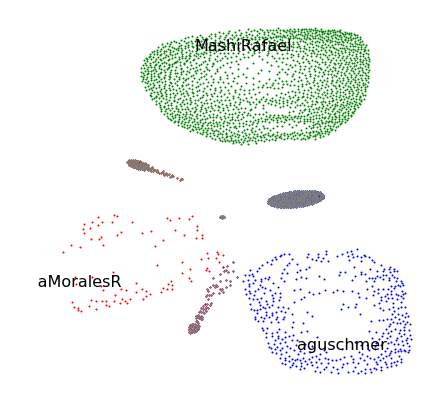

In [307]:
plt.figure
fig, ax = plt.subplots(figsize=(7,7))
ax.axis('off')
pos = nx.spring_layout(G,k=0.10,iterations=50)
group = list(G.predecessors('MashiRafael'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=group, node_color='green', node_shape='o')
group = list(G.predecessors('aguschmer'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=group, node_color='blue', node_shape='o')
group = list(G.predecessors('KarlaMoralesR'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=group, node_color='red', node_shape='o')
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=intergroup, node_color='grey', node_shape='x')
group=['MashiRafael','KarlaMoralesR','aguschmer']
labels = {name:name for name in group}
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black')

## sample conversations 

In [292]:
name_list=['MashiRafael','KarlaMoralesR','aguschmer']
conv_users = ds[ds.in_reply_to_status_id.isnull()]
conv_users = conv_users[conv_users.screen_name.isin(name_list)].groupby('screen_name')
users = {}
tweets  =[]

for name, group in conv_users:
    conv_ids= group.sample(5, random_state=1).conversation_id.values
    conv_tweets = ds[ds.conversation_id.isin(conv_ids)]
    conv_parts = conv_tweets.screen_name.nunique()    
    users[name] = set(conv_tweets.screen_name.unique())
    t=conv_tweets.groupby('screen_name').agg({'id': 'max'}).reset_index()
    tweets.extend(list(zip(t['screen_name'].values,t['id'].values)))
    print(name, conv_tweets.shape[0], conv_parts)

KarlaMoralesR 10 6
MashiRafael 159 117
aguschmer 34 30


In [259]:
user_list =[]
for key,value in users.items():
    user_list.extend(list(value))
    for key2,value2 in users.items():
        if key==key2:
            continue
        print(key,key2, len(list(value.intersection(value2))))

KarlaMoralesR MashiRafael 0
KarlaMoralesR aguschmer 0
MashiRafael KarlaMoralesR 0
MashiRafael aguschmer 0
aguschmer KarlaMoralesR 0
aguschmer MashiRafael 0


not intersection between users! we can use this sample as small dataset prediction or discussion analysis

In [293]:
users_to_crawl = pd.DataFrame(data=tweets, columns=['name', 'tweet_id'])
users_to_crawl.shape

(153, 2)

In [294]:
users_to_crawl.head()

,name,tweet_id
0,KarlaMoralesR,864679238045249545
1,TitoTacitus,746192692460191744
2,WilsonMerinoR,852353945007685632
3,andresgaraym,864680292191272963
4,ernestoColon20,753038888420147200


In [295]:
users_to_crawl.to_csv('../data/convusersec/sample_users_conv.csv', index=False)

## generate conversation stats

validation about conversations

In [3]:
ds[(ds.num_replies> 1)&(ds.num_users>1) ].conversation_id.nunique()

8787

get the number of dialogs generated with different contexts

In [17]:
words = {}
for i, row in tqdm(ds.iterrows()):
    tokens = row['text'].split()
    for t in tokens:
        words[t] = 1

520263it [00:52, 9893.58it/s]


In [30]:
n_conversations = ds.conversation_id.nunique()
n_tweets = ds.shape[0]
n_words = len(words)
n_users = ds.screen_name.nunique()

In [57]:
data_dir = '../data/convusersec/dialogs/'
num_dialogs = 0
utterances = []
turns = []
fnames = []

for f in tqdm( listdir(data_dir) ,'reading dialogs'):

    dialog_filename = join(data_dir, f)
    
    if not isfile(dialog_filename):
        continue
    if not f.endswith('.tsv'):
        continue
    
    num_dialogs += 1
    fnames.append(dialog_filename)    
    #print(dialog_filename)
    first_turn = True
    utterances_dialog = 0
    turns_dialog = 0

    with open(dialog_filename, 'r') as dialog_file:
        dialog_reader = csv.reader(dialog_file, delimiter='\t', quoting=csv.QUOTE_NONE)

        for dialog_line in dialog_reader:
            #print(dialog_line)
            if first_turn:
                last_user = dialog_line[1]
                turns_dialog += 1
                first_turn = False

            if last_user != dialog_line[1]:
                # user has changed
                turns_dialog += 1

            last_user = dialog_line[1]
            utterances_dialog += 1

        utterances.append(utterances_dialog)
        turns.append(turns_dialog)
    
    #break
fnames = np.array(fnames)
utterances = np.array(utterances)
turns = np.array(turns)    
print(f'num dialogs:{num_dialogs}')
print(f'num utterances:{len(utterances)}')
print(f'num turns:{len(turns)}')

reading dialogs: 100%|██████████| 65277/65277 [00:08<00:00, 7781.99it/s]


num dialogs:65274
num utterances:65274
num turns:65274


In [85]:
stats =[]
stats.append( ['pop. users', 3] )
stats.append( ['conversations', n_conversations] )
stats.append( ['tweets', n_tweets] )
stats.append( ['words', n_words] )

stats.append( ['conv. threads', num_dialogs] )
stats.append( ['utterances', utterances.sum()] )
stats.append( ['turns', turns.sum()] )

stats.append( ['min. turns', turns.min()] ) # this is manually defined
stats.append( ['avg. turns', turns.mean()])
stats.append( ['max. turns', turns.max()])
stats.append( ['median turns', np.median(turns)])

stats_df = pd.DataFrame(stats, columns=['stat', 'value'])
stats_df

,stat,value
0,pop. users,3.000000
1,conversations,12909.000000
2,tweets,520263.000000
3,words,588039.000000
4,conv. threads,65274.000000
5,utterances,345277.000000
6,turns,331971.000000
7,min. turns,1.000000
8,avg. turns,5.085808
9,max. turns,64.000000


### Why is min turns == 1???

In [59]:
fnames[turns==1]


array(['../data/convusersec/dialogs/914046965150814208.tsv',
       '../data/convusersec/dialogs/914045871536435201.tsv',
       '../data/convusersec/dialogs/914043246938136578.tsv',
       '../data/convusersec/dialogs/914033221574299648.tsv'], dtype='<U50')

In [76]:
!cat ../data/convusersec/dialogs/914046965150814208.tsv

2017-09-30 08:36:53	MashiRafael	Hoy es 30S. Hace siete años, por primera vez en la historia, el pueblo salió espontáneamente a defender a su Gobierno y Revolución.
2017-09-30 08:38:12	MashiRafael	El costo fue muy alto, pero Ecuador cambió y para siempre. Jamás volveríamos a permitir que el abuso y la fuerza atentaran contra nuestra..
2017-09-30 08:38:47	MashiRafael	...democracia.. Siempre nuestro homenaje a Juan Pablo Bolaños, Froilán Jiménez, Darwin Panchi, Jacinto Cortéz y Edwin Calderón, caídos el...
2017-09-30 08:39:13	MashiRafael	...día en que triunfó la democracia.. ¡Hasta la victoria siempre!


those are related to self replies

## choosing the max-content-len

- select the path of csv files generated in the preprocessing step
- this value defines the hyperparam for extracting content from the tfrecords

In [61]:
train = pd.read_csv('../data/convusersec/dialogs_csv_v3/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
Context      50000 non-null object
Utterance    50000 non-null object
Label        50000 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [71]:
train['num_words'] = train.Context.apply(lambda x: len(x.split()))

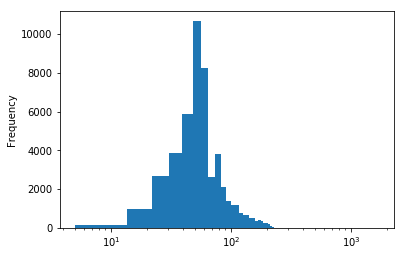

In [72]:
train.num_words.plot.hist(bins=200)
plt.xscale('log')

## final stats

In [91]:
stats =[]
stats.append( ['pop. users', 3] )
stats.append( ['conversations', n_conversations] )
stats.append( ['tweets', n_tweets] )
stats.append( ['words', n_words] )

stats.append( ['conv. threads', num_dialogs] )
stats.append( ['utterances', utterances.sum()] )
stats.append( ['turns', turns.sum()] )

stats.append( ['min. turns', turns.min()] ) # this is manually defined
stats.append( ['avg. turns', turns.mean()])
stats.append( ['max. turns', turns.max()])
stats.append( ['median turns', np.median(turns)])

stats.append( ['min. context words', np.min(train.num_words)] ) # this is manually defined
stats.append( ['avg. context words', np.mean(train.num_words)])
stats.append( ['max. context words', np.max(train.num_words)])
stats.append( ['median context words', np.median(train.num_words)])


stats_df = pd.DataFrame(stats, columns=['stat', 'value'])
stats_df

,stat,value
0,pop. users,3.000000
1,conversations,12909.000000
2,tweets,520263.000000
3,words,588039.000000
4,conv. threads,65274.000000
5,utterances,345277.000000
6,turns,331971.000000
7,min. turns,1.000000
8,avg. turns,5.085808
9,max. turns,64.000000


In [92]:
stats_df.to_csv('../results/ds_stats_conversations.csv', index=False)

## plot distribution for conversations

In [11]:
convdist = ds[(ds.num_replies>1) & (ds.in_reply_to_status_id.isnull())]
convdist.num_replies.head()

0     3
11    2
14    7
21    2
25    2
Name: num_replies, dtype: int64

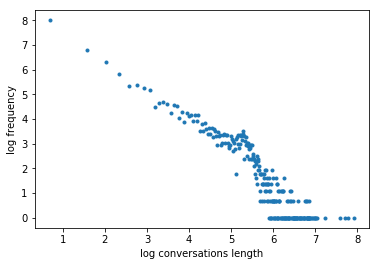

In [28]:
y, bins = np.histogram(convdist.num_replies, bins=1000)
x=bins[:-1]
ix = y!=0
y_log = np.log(y[ix])
x_log = np.log(x[ix])
plt.scatter(x_log, y_log, marker='.')
plt.xlabel('log conversations length')
plt.ylabel('log frequency')
plt.savefig('conversations_distribution.eps', format='eps',bbox_inches='tight')

In [88]:
import powerlaw
data = convdist.num_replies.values
results = powerlaw.Fit(data, discrete=True, xmin=2)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print(R,p)

1.4368275542071471
2.0
-475.16957769914654 2.598467693989193e-90


In [48]:
len(np.unique(data)), len(data>1), len(data)

(500, 8793, 8793)

In [49]:
power_law = results.power_law.pdf()
len(power_law)

8793

In [50]:
exponential = results.exponential.pdf()
len(exponential)

8793

In [79]:
bins, empirical = results.pdf(bins=500)
len(bins), len(empirical)

(501, 500)

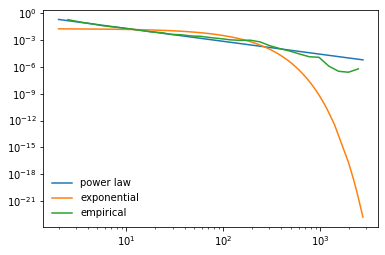

In [82]:
ax= results.power_law.plot_pdf(label='power law')
ax2=results.exponential.plot_pdf(label='exponential')
ax3=results.plot_pdf(label='empirical')
plt.legend(frameon=False)

In [73]:
len(ax.lines), ax.lines[0].get_xydata().shape,ax.lines[1].get_xydata().shape, ax.lines[2].get_xydata().shape

(3, (500, 2), (500, 2), (30, 2))

In [86]:
powerlaw = ax.lines[0].get_xydata()
exponential= ax.lines[1].get_xydata()
empirical = ax.lines[2].get_xydata()

powerlaw_ds = pd.DataFrame(powerlaw, columns=['bins', 'pdf'])
exponential_ds = pd.DataFrame(exponential, columns=['bins', 'pdf'])
empirical_ds = pd.DataFrame(empirical, columns=['bins', 'pdf'])

pd.concat([powerlaw_ds.head(), exponential_ds.head(), empirical_ds.head()], axis=1)

,bins,pdf,bins,pdf,bins,pdf
0,2.0,0.194686,2.0,0.017330,2.5,0.183669
1,3.0,0.108723,3.0,0.017029,3.5,0.091778
2,4.0,0.071913,4.0,0.016734,4.5,0.061754
3,5.0,0.052187,5.0,0.016444,5.5,0.041055
4,6.0,0.040160,6.0,0.016159,7.0,0.030081


In [87]:
powerlaw_ds.to_csv('powerlaw_dist.csv', index=False)
exponential_ds.to_csv('exponential_dist.csv', index=False)
empirical_ds.to_csv('empirical_dist.csv', index=False)

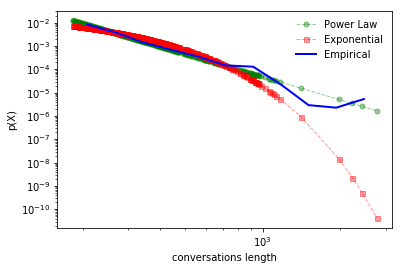

In [45]:
from powerlaw import plot_pdf, Fit, pdf
#https://pypi.org/project/powerlaw/
#http://nbviewer.jupyter.org/github/jeffalstott/powerlaw/blob/master/manuscript/Manuscript_Code.ipynb
#plot_pdf(data, color='b', linewidth=2)
#results.power_law.plot_pdf(linestyle=':', color='g')
results.power_law.plot_pdf( linestyle='--', color='g', marker='o',markersize=5, linewidth=1,alpha=0.4, label='Power Law')
results.exponential.plot_pdf(linestyle='--', color='r', marker='s',markersize=5,linewidth=1,alpha=0.4, label='Exponential')
results.plot_pdf(color='b', linewidth=2, label=r'Empirical')
plt.legend(frameon=False)
plt.xlabel('conversations length')
plt.ylabel('p(X)')
plt.savefig('../results/conversations_distribution.eps', format='eps',bbox_inches='tight')

# trec dataset

In [2]:
data_dir = '~/data/twconv/trec/'

In [4]:
path = os.path.join(data_dir, 'tweets_conv.csv')
ds = pd.read_csv(path, dtype=object)
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 14 columns):
id                       29568 non-null object
screen_name              29568 non-null object
text                     29568 non-null object
in_reply_to_status_id    23803 non-null object
created_at               29568 non-null object
latitude                 70 non-null object
longitude                70 non-null object
lang                     29568 non-null object
timestamp                29555 non-null object
conversation_id          29568 non-null object
conversation_deep        29568 non-null object
num_replies              29568 non-null object
num_users                29568 non-null object
url                      29568 non-null object
dtypes: object(14)
memory usage: 3.2+ MB


distribution of the users

In [13]:
stat=ds.groupby('screen_name').size().sort_values().reset_index()
stat.columns=['name','ntweets']
stat.groupby('ntweets').size().head(10)

ntweets
1     3673
2     1503
3      840
4      519
5      299
6      238
7      189
8      102
9      105
10      92
dtype: int64

## determine the value for max_sentence_len in tfbuilder
lets analyze the data for training

In [15]:
data_dir = '~/data/twconv/trec/dialogs/'

In [16]:

path = os.path.join(data_dir, 'train.csv')
trainds = pd.read_csv(path)
trainds.shape

(35254, 3)

In [18]:
trainds['content_nwords'] = trainds.context.apply(lambda c: len(c.split()))

In [22]:
trainds.head()

,context,profile,flag,content_nwords
0,pretty bored. lol. Lol ! You love bored ? &gt;...,pretty bored. lol. @Anaelledu45 noo. i hate.. ...,1,47
1,pretty bored. lol. Lol ! You love bored ? &gt;...,Fluxus Interruptus - DadaBrats at play: http:/...,0,47
2,pretty bored. lol. Lol ! You love bored ? &gt;...,Lol ! You love bored ? &gt; &gt; @Simpsonluvie...,1,47
3,pretty bored. lol. Lol ! You love bored ? &gt;...,"@LeahBraemel @Kristen_Howe And yet, figuring o...",0,47
4,pretty bored. lol. Lol ! You love bored ? &gt;...,pretty bored. lol. @Anaelledu45 noo. i hate.. ...,1,47


In [26]:
nwords = trainds.groupby('source').agg({'content_nwords': 'max'}).reset_index()
nwords.shape

(3409, 2)

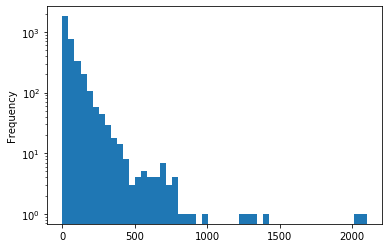

In [28]:
nwords.content_nwords.plot.hist(bins=50)
plt.yscale('log')

In [36]:
np.percentile(nwords.content_nwords, 90)

164.0

In [37]:
nwords = trainds.groupby('profile').agg({'content_nwords': 'max'}).reset_index()
nwords.shape

(4130, 2)

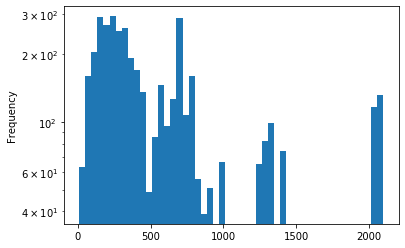

In [38]:
nwords.content_nwords.plot.hist(bins=50)
plt.yscale('log')

In [40]:
np.percentile(nwords.content_nwords, 75)

737.0

for the users profiles the lenght of the text is huge , even for 75 percentile, so we need to reduce through topic modeling, the question , a prior step? or jointly trained?

the options are:
- try using truncated profile to the same length as the context 
- use topic modeling to compress to fixed lenght
- use jointly modeling 